In [1]:
import pandas as pd
import meshio as mio
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import trapezoid
from scipy.interpolate import lagrange

# Leitura de malha
<hr/>
- Leitura de malha, se necessário.

# Pós-processamento da plotagem do perfil sobre o retalho
<hr/>
- O retalho é a região escolhida com "Extract Selection".
- A largura dele na direção "y" deve ser escolhida em cada caso.

In [2]:
vtu = mio.read('rugoso_standoff/velocidade-134000000.vtu')
coords = vtu.points  # coordenadas x,y,z (z=0 para 2D)
vel = vtu.point_data['f_24']  # campo vetorial (velocidada aqui)
conn = vtu.cells_dict['triangle']  # matriz de conectividade (índice de nós dos elementos)
mesh = 


In [3]:
# leia arquivo de dados do perfil
df = pd.read_csv('rugoso_standoff/rugoso_baixo/202.csv')

In [4]:
# Os nan provêm dos pontos que não intersectam a malha.
# Aqui limpamos o dataframe e resetamos o index
df = df.dropna().reset_index(drop=True)
#df

- Componentes de velocidade e módulo

In [5]:
vx = df['f_24:0']
vy = df['f_24:1']
v = np.sqrt(vx**2 + vy**2).values
#df

- Eixo "x"

In [6]:
x = df['Points:0'].values

In [31]:
x

array([ 21.16 ,  21.3  ,  21.44 ,  21.58 ,  21.721,  21.861,  22.001,
        22.142,  22.282,  22.422,  22.562,  22.703,  22.843,  22.983,
        23.124,  23.264,  23.404,  23.545,  23.685,  23.825,  23.965,
        24.106,  24.246,  24.386,  24.527,  24.667,  24.807,  24.947,
        25.088, 141.67 , 141.81 , 141.95 , 142.09 , 142.23 , 142.37 ,
       142.52 , 142.66 , 142.8  , 142.94 , 143.08 , 143.22 , 143.36 ,
       143.5  , 143.64 , 143.78 , 143.92 , 144.06 , 144.2  , 144.34 ,
       144.48 , 144.62 , 144.76 , 144.9  , 145.04 , 145.18 , 145.32 ,
       145.46 , 145.6  , 145.74 , 145.88 , 146.02 , 146.16 , 146.3  ,
       146.44 , 146.58 , 146.72 , 146.86 , 147.   , 147.14 , 147.29 ,
       147.43 , 147.57 , 147.71 , 147.85 , 147.99 , 148.13 , 148.27 ,
       148.41 , 148.55 , 148.69 , 148.83 , 148.97 , 149.11 , 149.25 ,
       149.39 , 149.53 , 149.67 , 149.81 , 149.95 , 150.09 , 150.23 ,
       150.37 , 150.51 , 150.65 , 150.79 , 150.93 , 151.07 , 151.21 ,
       151.35 , 151.

- Plotagem dos perfis sobre a linha

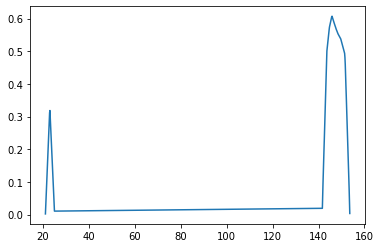

In [7]:
plt.plot(x,v);

In [42]:
nao_nulo_esq = np.argwhere((x < 24)).flatten()
nao_nulo_dir = np.argwhere((x > 100)).flatten()

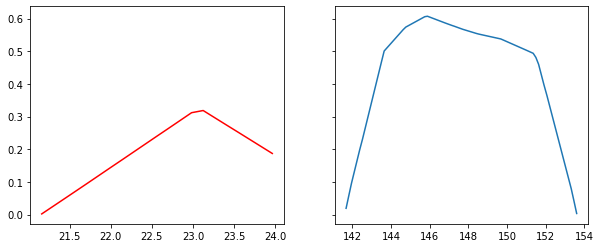

In [46]:
fig,ax = plt.subplots(1,2,figsize=(10,4),sharey=True)
ax[0].plot(x[nao_nulo_esq],v[nao_nulo_esq],color='r')
ax[1].plot(x[nao_nulo_dir],v[nao_nulo_dir]);

-  Separação dos lados

In [10]:
E = x[nao_nulo_esq]; 
D = x[nao_nulo_dir];
h_e = np.max(E) - np.min(E)
h_d = np.max(D) - np.min(D)
h_e, h_d

(3.928000000000001, 11.930000000000007)

-  Calculando "vazões": $Qe = \int{he} ve dx$ e $Qd = \int{hd} vd dx$
-  Aplicamos integração numérica e regra do trapézio

In [11]:
v_e = v[nao_nulo_esq]; 
v_d = v[nao_nulo_dir]
Q_e = trapezoid(v_e)
Q_d = trapezoid(v_d)
Q_e, Q_d

(4.662911759666908, 38.54014669259297)

# Definição de zona intermediária
<hr/>
- Para o cálculo da eficiência, é necessário "excluir" o efeito da parede interna do poço (velocidade nula) e o efeito da parede externa do poço (perturbação).
- No ânulo esquerdo, o efeito de parede é do lado direto e o de erosão do lado esquerdo.
- No ânulo direito, o efeito de parede é do lado esquerdo e o de erosão do lado direito.
- Sob efeito de standoff, a coisa precisa ser estudada.
- Aqui vou adotar um percentual arbitrário. Excluirei X% de ambos os lados do ânulo.

In [12]:
X = 0.1
delta_e = X*h_e
delta_d = X*h_d
limite_zona_limpa_e = (delta_e,h_e - delta_e) # h_a
limite_zona_limpa_d = (delta_d,h_d - delta_d) # h_b
print(limite_zona_limpa_e, limite_zona_limpa_d, sep='\t')

(0.3928000000000001, 3.5352000000000006)	(1.1930000000000007, 10.737000000000005)


In [13]:
ve = v[nao_nulo_esq]
xe = np.linspace(0,h_e,len(ve))
vd = v[nao_nulo_dir]
xd = np.linspace(0,h_d,len(vd))

regiao_limpa_e = np.argwhere(((xe < limite_zona_limpa_e[1])&(xe > limite_zona_limpa_e[0]))).flatten()
regiao_limpa_d = np.argwhere(((xd < limite_zona_limpa_d[1])&(xd > limite_zona_limpa_d[0]))).flatten()

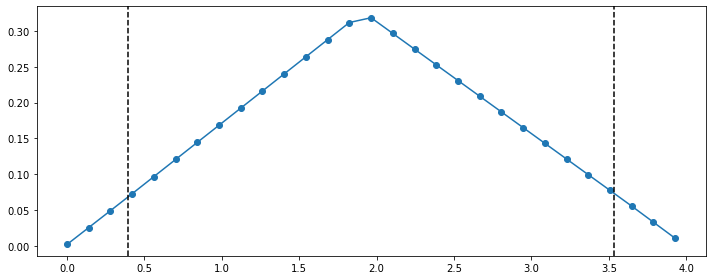

In [14]:
#Região esquerda
ve = v[nao_nulo_esq]
xe = np.linspace(0,h_e,len(ve))

plt.figure(figsize=(10,4))
plt.plot(xe,ve)
plt.scatter(xe,ve)
plt.axvline(x=limite_zona_limpa_e[0],c='k',ls='--')
plt.axvline(x=limite_zona_limpa_e[1],c='k',ls='--');
plt.tight_layout()

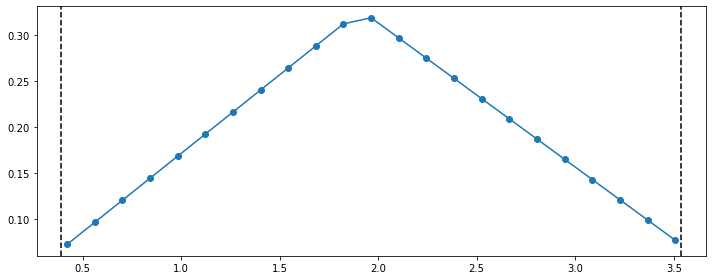

In [15]:
#Região limpa esquerda
ve = ve[regiao_limpa_e]
xe = xe[regiao_limpa_e]

plt.figure(figsize=(10,4))
plt.plot(xe,ve)
plt.scatter(xe,ve)
plt.axvline(x=limite_zona_limpa_e[0],c='k',ls='--')
plt.axvline(x=limite_zona_limpa_e[1],c='k',ls='--');
plt.tight_layout()

In [16]:
Qlimpo_e = trapezoid(ve)
print(Q_e, Qlimpo_e)

4.662911759666908 4.417445018127023


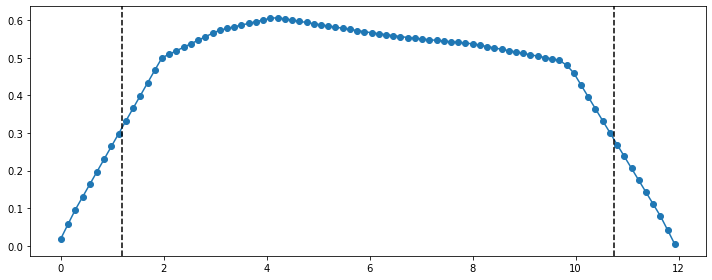

In [17]:
#Região direita
vd = v[nao_nulo_dir]
xd = np.linspace(0,h_d,len(vd))
plt.figure(figsize=(10,4))
plt.plot(xd,vd)
plt.scatter(xd,vd)
plt.axvline(x=limite_zona_limpa_d[0],c='k',ls='--')
plt.axvline(x=limite_zona_limpa_d[1],c='k',ls='--');
plt.tight_layout()

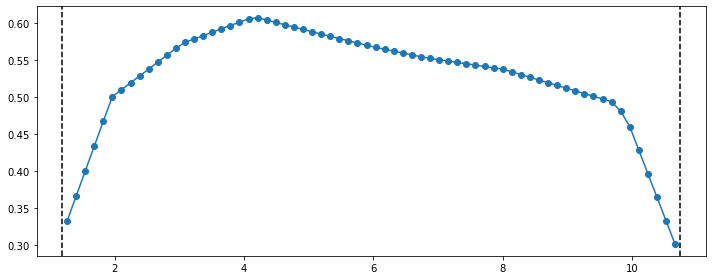

In [18]:
#Região limpa esquerda
vd = vd[regiao_limpa_d]
xd = xd[regiao_limpa_d]
plt.figure(figsize=(10,4))
plt.plot(xd,vd)
plt.scatter(xd,vd)
plt.axvline(x=limite_zona_limpa_d[0],c='k',ls='--')
plt.axvline(x=limite_zona_limpa_d[1],c='k',ls='--');
plt.tight_layout()

In [19]:
Qlimpo_d = trapezoid(vd)
print(Q_d, Qlimpo_d)

38.54014669259297 35.511490005361054


- Você deve integrar os perfis de velocidade nos intervalos $[ha,hb]$ para obter $Q{limp} = \int{ha}^{hb} v dx$

In [23]:
n_e = Qlimpo_e/Q_e
n_d = Qlimpo_d/Q_d
n = n_d/n_e#

print(n_e, n_d,n)


0.9473576266951662 0.9214155381558526 0.9726163723093549


# Estudo de Casos
<hr/>

- Supondo apenas o lado esquerdo e $Q{limp} = Q{limp,e}$, você tem $\eta = \frac{Qe - Q{limp,e}}{Q_{limp,e}}$

- Faça o mesmo pro lado direito.

- Repita a análise acima para 3 retas dentro de cada retalho e para 3 retalhos ao longo
da coluna do poço.

- Retas seriam, por exemplo: linhaIJ, com I nomeando o retalho e J a reta dentro do
retalho I. Escolha as coordenadas y e procure selecionar um retalho com larguras em y
próximas.

- Faça figuras da malha no Paraview, exporte os CSV por lá e pós-processe a
matemática aqui.